In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# TODOs (from 09.06.2020)

1. Strip away the non-useful functions
2. Document the remaining functions
3. Move the remaining functions to modules
4. Test the modules
5. Clean up this NB

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [3]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

dsec = 1/3600.0
time = np.arange(0,24,dsec)
stays = [
        get_stay(  0.00,  6.00,-1.00), #home
        get_stay(  7.50, 16.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]

t_segs, x_segs = get_stay_segs(stays)


raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))


dup_mask = get_mask_with_duplicates(time, 0.05, 0.3)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)      

noises = get_noise_arr(0.02, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

**Figure** in the above plot, time is on the "x"-axis. An interpretation of this motion, is that the user is initially making a "stay" at a location near $x=-1$, then makes another stay at $x=1$, ending with a return to the initial location. As with all of this data, there is an intrinsic noise that must be considered.

# Goal: Stay detection and positioning

The goal is to identify stays by their beginnings and ends, and associate them to a position. This effectively means to optimally match clusters of points with flat lines.

For a set of events within a cluster $\mathcal{C}_l =  \{e_i \; | \; i = [m,n]_l \subset [0,N-1]\}$, a "flat line" has $|\mathbf{x}_m-\mathbf{x}_n| = 0$. Again, this is easiest to see in 1D but it also holds in 2D.


# Strategy

To find the stays, we consider some requirements.

Firstly, there are two main requirements (previously noted):
1. identify the start/stop of a stay
2. estimate a dominant location, _ie_ the "central location" of the stay
    * this is where the agent spends the majority of the time, _e.g._ within a building, at a park, etc.

Then, there are some minor rquirements:
1. the clusters should contain a minimum number of points
2. the duration between the first and last points should exceed $\Delta t$
3. the clusters should be as long (in time) as possible
    * if there is a sufficient temporal break between two consecutive events without a significant location change, then on must specify how this is to be dealt with.
4. the clusters should contain as many events as possible

One additional requirement which affects all of the above: **cluster outliers should be identified and ignored** 
* outliers can change the central location and also the beginning/ending of the clusters
* from the calculation of the central location
    * counting them could still help in identifying a cluster wihtout using their position
    
All of these must be considered together.

This clearly defines an optimization problem: 
* maximize the length of the fit line, while 
    * mimimizing its error by adjusting its position ($\mathrm{x}_{\mathrm{opt.}}$) and end-regions ($t_{\mathrm{start}}, t_{\mathrm{stop}}$)
    * ignoring the outliers.

**Notes** 

* When the error is the mean squared error: $\epsilon := \sqrt{ \frac{1}{N}\sum^N_i(\mathrm{x}_i-\mathrm{x}_{\mathrm{opt.}})^2}$; 
    * this simplifies the position since the mean (or "centroid") is the value of $\mathrm{x}_{\mathrm{opt.}}$ which minimizes this error, leaving only the adjustment of the end-regions and outliers for the optimization task.

This suggests that there is at least a solution to this problem: 
One could consider all possible combinations of subsequences and all possible combinations of their outliers, and measure error, and then pick any from the set of lowest error subsequence-outlier combination fits. However, this is similar to the maximum subarray problem, and in the worst case it would be $\mathcal{O}(n^3)$.

It's countably finite, but impractical approach; itcan be a benchmark to compare all other algorithms which aim to do the same within some acceptable error.

### The Box

In [4]:
eps = 0.25

In [5]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

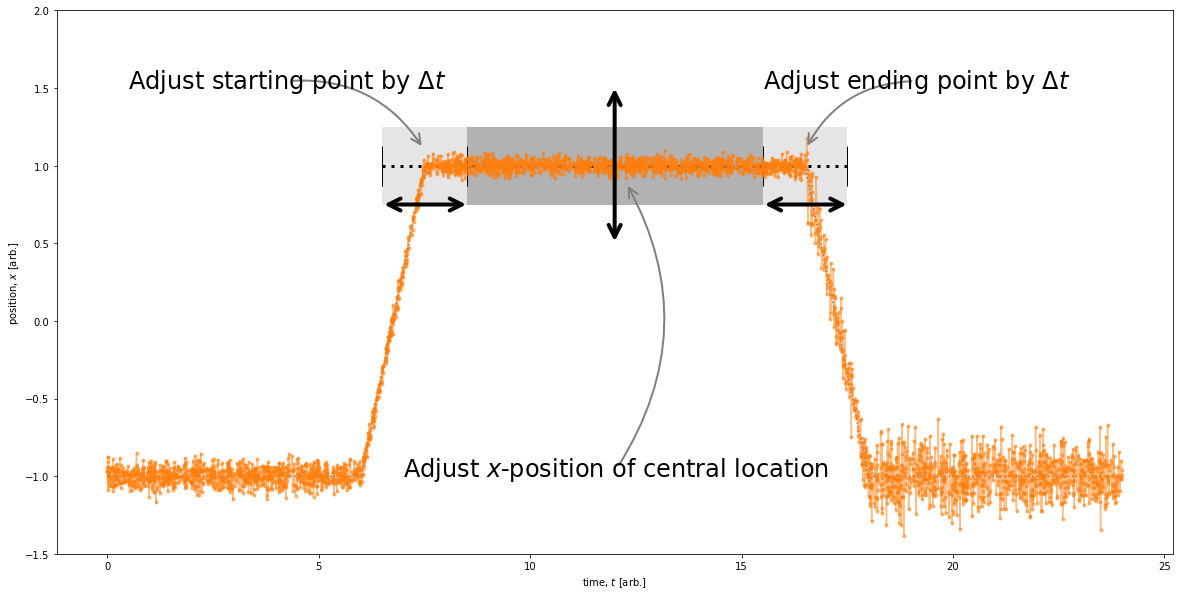

In [6]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

begin = t_segs[3]+1
begin_buff = begin-2
end = t_segs[4]-1
end_buff = end+2

loc = x_segs[3]


rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)

ax.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
ax.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

#plt.plot(t_segs[3:5], x_segs[3:5], '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, raw_journey_sub, ':', label='raw journey')
ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)




# Create patch collection with specified colour/alpha
pc = PatchCollection([rect_outer], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)

rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)
pc2 = PatchCollection([rect_inner], \
                     facecolor='gray', alpha=0.5, edgecolor='k',linewidth=0)


# Add collections to axes
ax.add_collection(pc)
ax.add_collection(pc2)


# interface tracking profiles
arrowprops=dict(arrowstyle="<->", 
                shrinkA=0.5,
                mutation_scale=30.0,
                connectionstyle="arc3", linewidth=4.0)
# the arrows
arrowcentery = 1.0
arrowcenterx = 12
arrowcenterh = 0.5
ax.annotate("", xy=(arrowcenterx, arrowcentery-arrowcenterh), xytext=(arrowcenterx, arrowcentery+arrowcenterh),
             arrowprops=arrowprops)

dt_arrowcentery = 0.25
ax.annotate("", xy=(begin_buff, arrowcentery-dt_arrowcentery), xytext=(begin, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)

ax.annotate("", xy=(end, arrowcentery-dt_arrowcentery), xytext=(end_buff, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)


mid_point = lambda x1,x2: 0.5*(x1+x2)

delta_t_texty = 1.5
ax.annotate(r"Adjust starting point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(begin,begin_buff), 1.1), xycoords='data',
            xytext=(begin-8,delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=-0.3", linewidth=2.0
                            ),
            )
ax.annotate(r"Adjust ending point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(end,end_buff), 1.1), xycoords='data',
            xytext=(end, delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

ax.annotate(r"Adjust $x$-position of central location",fontsize= 24,
            xy=(arrowcenterx+0.25, arrowcentery-0.1), xycoords='data',
            xytext=(arrowcenterx-5, arrowcentery-2.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

'''plt.text(0, 0.1, r'$\delta$',
         {'color': 'black', 'fontsize': 24, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
'''
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)
plt.grid(visible=False);

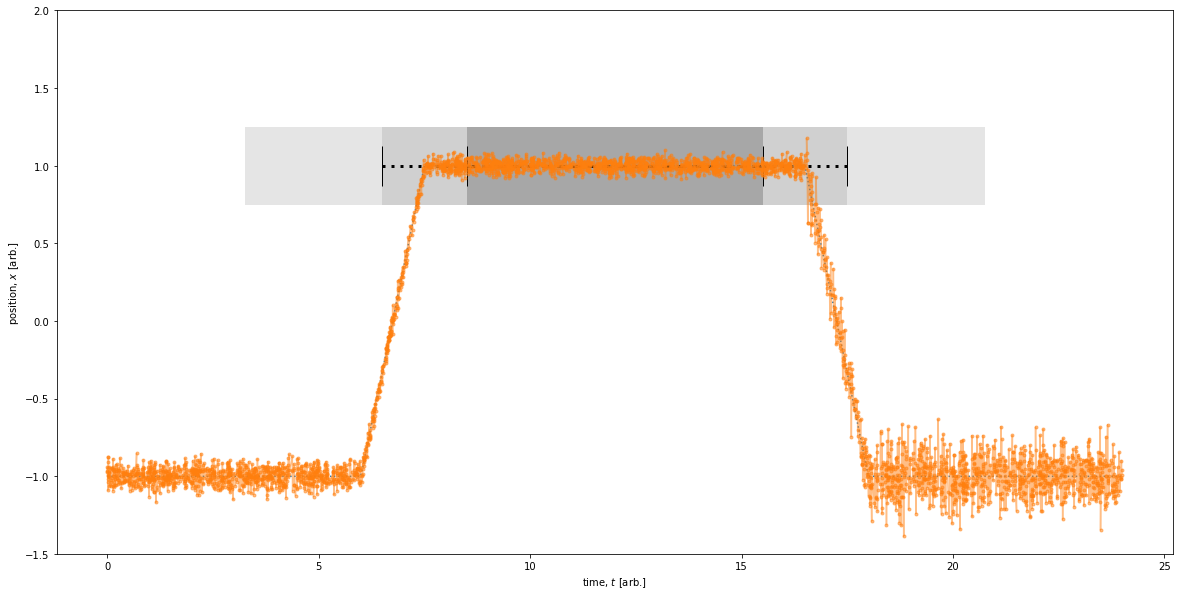

In [7]:
eps = 0.25
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)

ax.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
ax.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

#plt.plot(t_segs[3:5], x_segs[3:5], '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, raw_journey_sub, ':', label='raw journey')
ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)


rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# Create patch collection with specified colour/alpha
pc = PatchCollection([rect_outer2], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)
# Create patch collection with specified colour/alpha
pc1 = PatchCollection([rect_outer], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)

pc2 = PatchCollection([rect_inner], \
                     facecolor='gray', alpha=0.5, edgecolor='k',linewidth=0)


# Add collection to axes
ax.add_collection(pc)
ax.add_collection(pc1)
ax.add_collection(pc2)

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)
plt.grid(visible=False);

Once the box (width is provided by the spatial tolerance) is positioned in a good way (_ie_ the centroid), extending the box forwards or backwards in time makes no change to the _score_ of the box.

Here, the score could be something like the number of points, the std/MSE; whatever it is, it should be saturated at some point and extending the box makes no difference, meaning that something converges which provides a stopping criterion. 

### Box method

In [8]:
box_start = np.where((time_sub < 12.2) & (time_sub > 11.8))[0].min()
box_end = np.where((time_sub < 13.0) & (time_sub > 12.5))[0].max()

In [9]:
def get_counts(eps, mean):
    
    upper = mean+eps
    lower = mean-eps
    
    def meth(sub_arr):
        
        return np.where((sub_arr < upper) & (sub_arr > lower))[0].size
    
    return meth
    

In [10]:
def get_thresh_mean(eps, mean):
    
    upper = mean+eps
    lower = mean-eps
    
    def meth(sub_arr):
        
        mask =  np.where((sub_arr < upper) & (sub_arr > lower))
    
        return np.mean(sub_arr[mask])
        
    return meth
    

In [11]:
new_start, new_end = box_start, box_end

mean = np.mean(noise_journey_sub[new_start:new_end])
eps = 0.25


time_thresh = 5/12
tdiffs2 = [time_sub[new_end]-time_sub[new_start]]
counts2 = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]
means = [mean]
new_starts = []
new_ends = []

new_starts.append(time_sub[new_start])
new_ends.append(time_sub[new_end])

while (new_start > 1) & (new_end < len(time_sub)-1):
    
    count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])
    
    counts2.append(count)
        
    new_start -= 1
    new_end += 1
            
    mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])
    means.append(mean)    
    
    new_starts.append(time_sub[new_start])
    new_ends.append(time_sub[new_end])
    
    tdiffs2.append(time_sub[new_end]-time_sub[new_start])
    #break
    


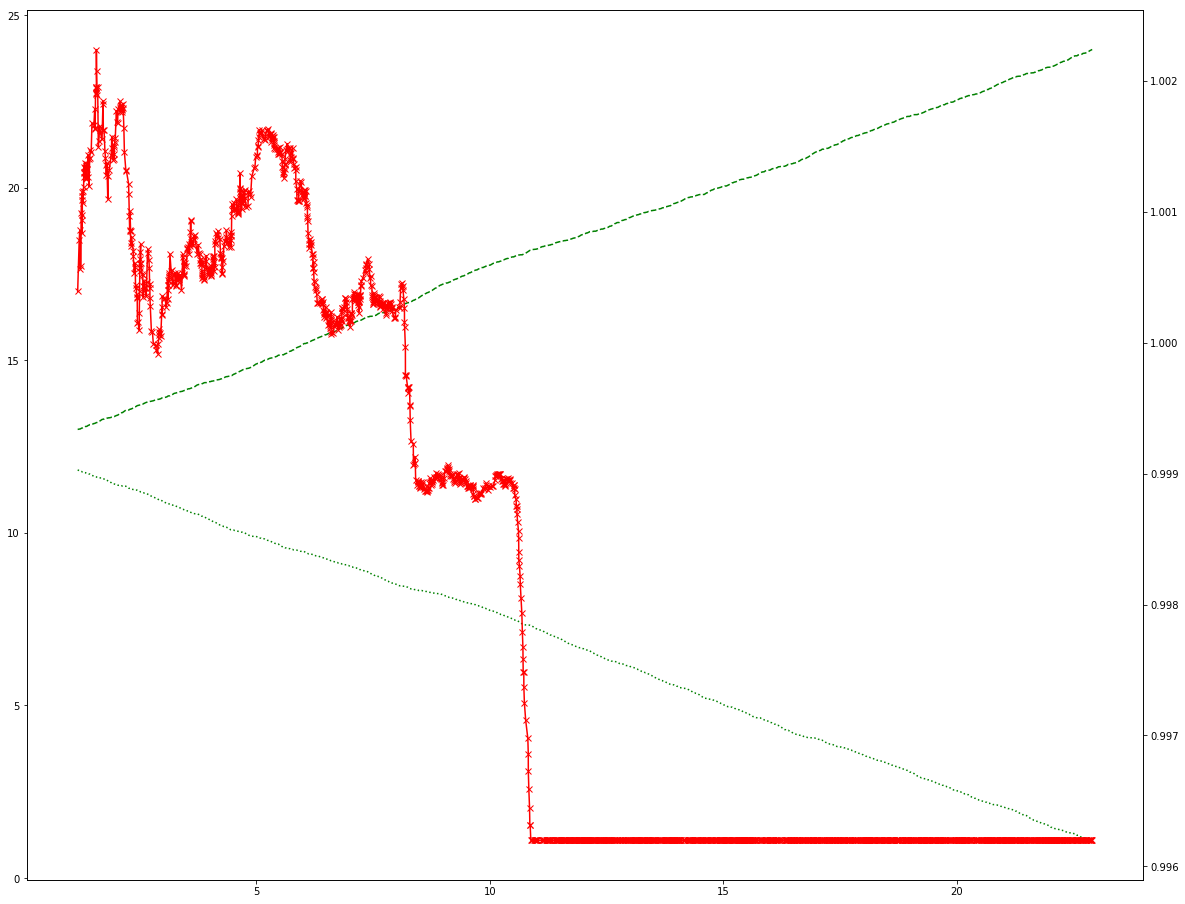

In [12]:
fig, ax = plt.subplots(1,1,figsize=[20,16])
ax.plot(tdiffs2, new_starts, 'g:')
ax.plot(tdiffs2, new_ends, 'g--')
axt = ax.twinx()
axt.plot(tdiffs2, means, 'rx-')

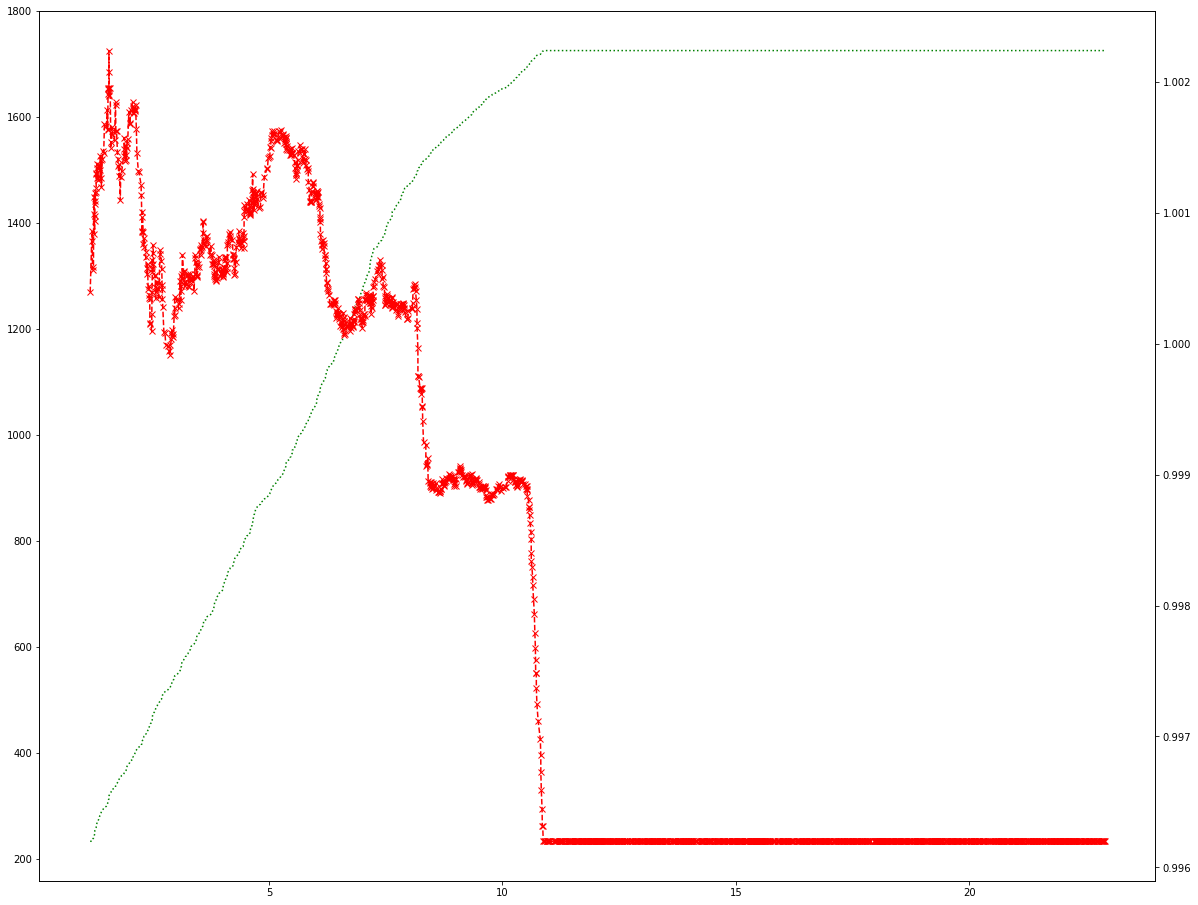

In [13]:
fig, ax = plt.subplots(1,1,figsize=[20,16])
ax.plot(tdiffs2, counts2, 'g:')
axt = ax.twinx()
axt.plot(tdiffs2, means, 'rx--')

In [14]:
timepoint = 5.0

box_start = np.where((time_sub < (timepoint)) & (time_sub > (timepoint-time_thresh)))[0].min()
box_end = np.where((time_sub < (timepoint+time_thresh)) & (time_sub > (timepoint)))[0].max()    

new_start, new_end = box_start, box_end

mean = np.mean(noise_journey_sub[new_start:new_end])


eps = 0.25

time_thresh = 5/12
tdiffs2 = [time_sub[new_end]-time_sub[new_start]]
counts2 = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]

means = [mean]

new_starts = []
new_ends = []

new_starts.append(new_start)
new_ends.append(new_end)

while (new_start > 1) | (new_end < len(time_sub)-1):
    
    count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])
    
    counts2.append(count)
        
    if (new_start > 1):
        new_start -= 1
    if (new_end < len(time_sub)-1):
        new_end += 1
    
    mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])
    means.append(mean)    
    
    tdiffs2.append(time_sub[new_end]-time_sub[new_start])

    new_starts.append(new_start)
    new_ends.append(new_end)

    count_thresh = 50
    if len(means)>count_thresh:
        m0 = means[-count_thresh]
        if all([m == m0 for m in means[-count_thresh:]]):
            last_mean = means[-count_thresh]
            last_start = new_starts[-count_thresh]
            last_end = new_ends[-count_thresh]
            print(last_mean,last_start,last_end)
            break
    


-0.9929456568571601 1 1854


In [15]:
timepoint = 5.0
eps = 0.25
time_thresh = 5/12

def box_method(t_arr,time_thresh,x_loc,eps,timepoint, verbose=False):

    box_start = np.where((t_arr < (timepoint)) & (t_arr > (timepoint-time_thresh)))[0].min()
    box_end = np.where((t_arr < (timepoint+time_thresh)) & (t_arr > (timepoint)))[0].max()    

    new_start, new_end = box_start, box_end

    mean = np.mean(x_loc[new_start:new_end])

    tdiffs2 = [t_arr[new_end]-t_arr[new_start]]
    counts2 = [get_counts(eps,mean)(x_loc[new_start:new_end])]

    means = [mean]

    new_starts = []
    new_ends = []

    new_starts.append(new_start)
    new_ends.append(new_end)

    while (new_start > 1) | (new_end < len(t_arr)-1):

        count = get_counts(eps,mean)(x_loc[new_start:new_end])

        counts2.append(count)

        if (new_start > 1):
            new_start -= 1
        if (new_end < len(t_arr)-1):
            new_end += 1

        mean = get_thresh_mean(eps,mean)(x_loc[new_start:new_end])
        means.append(mean)    

        tdiffs2.append(t_arr[new_end]-t_arr[new_start])

        new_starts.append(new_start)
        new_ends.append(new_end)
        
        if verbose: print(mean, new_start, new_end)
        
        count_thresh = 50
        if len(means)>count_thresh:
            m0 = means[-count_thresh]
            if all([m == m0 for m in means[-count_thresh:]]):
                last_mean = means[-count_thresh]
                last_start = new_starts[-count_thresh]
                last_end = new_ends[-count_thresh]
                break

    return last_mean,last_start,last_end

In [16]:
box_method(time_sub,time_thresh,noise_journey_sub,eps,3.0, True)

-1.0003430513101288 484 640
-1.0005668507422891 483 641
-0.9996699035218644 482 642
-0.9995672430479445 481 643
-0.9996979994747037 480 644
-0.9996132920141165 479 645
-0.9997533254776049 478 646
-0.9994527495021045 477 647
-0.9996298773670532 476 648
-0.9993645956004767 475 649
-0.9998333932175242 474 650
-0.9996322137742158 473 651
-0.9994681774504617 472 652
-0.9997701278482971 471 653
-0.9996739982904197 470 654
-0.9992217818670286 469 655
-0.9992814895761357 468 656
-0.9989255058228238 467 657
-0.9990203079901449 466 658
-0.9987729941276039 465 659
-0.9990549161854684 464 660
-0.9988830384746444 463 661
-0.998368255383999 462 662
-0.9983072390884566 461 663
-0.9981138900610413 460 664
-0.9980066494741471 459 665
-0.9981752501902744 458 666
-0.9984301119305956 457 667
-0.9981985704408515 456 668
-0.9987601429014362 455 669
-0.9990926066292808 454 670
-0.9992110840162691 453 671
-0.9986085099161234 452 672
-0.9987751404537397 451 673
-0.9985765289219243 450 674
-0.9984671561897904 4

(-0.9929456568571601, 1, 1135)

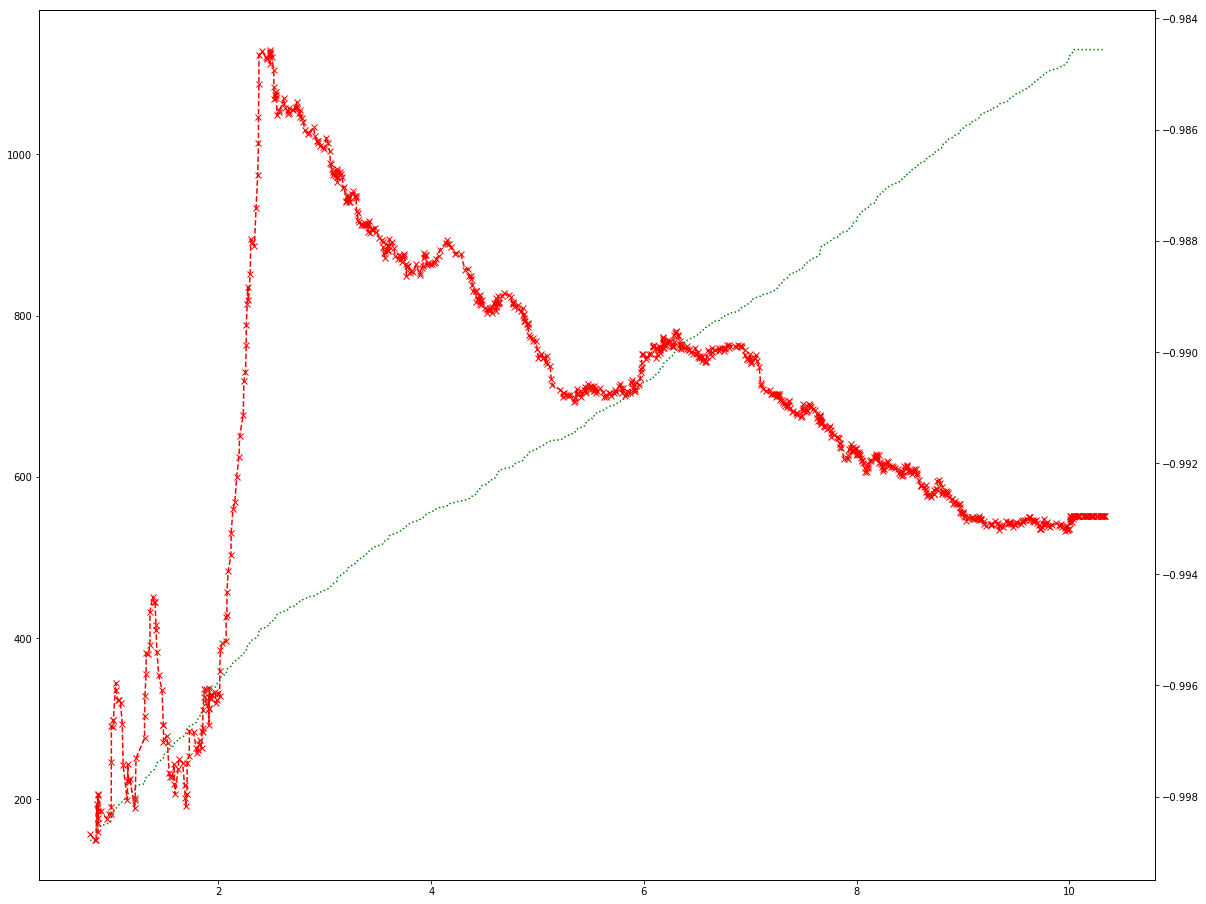

In [17]:

fig, ax = plt.subplots(1,1,figsize=[20,16])
ax.plot(tdiffs2, counts2, 'g:')
axt = ax.twinx()
axt.plot(tdiffs2, means, 'rx--')

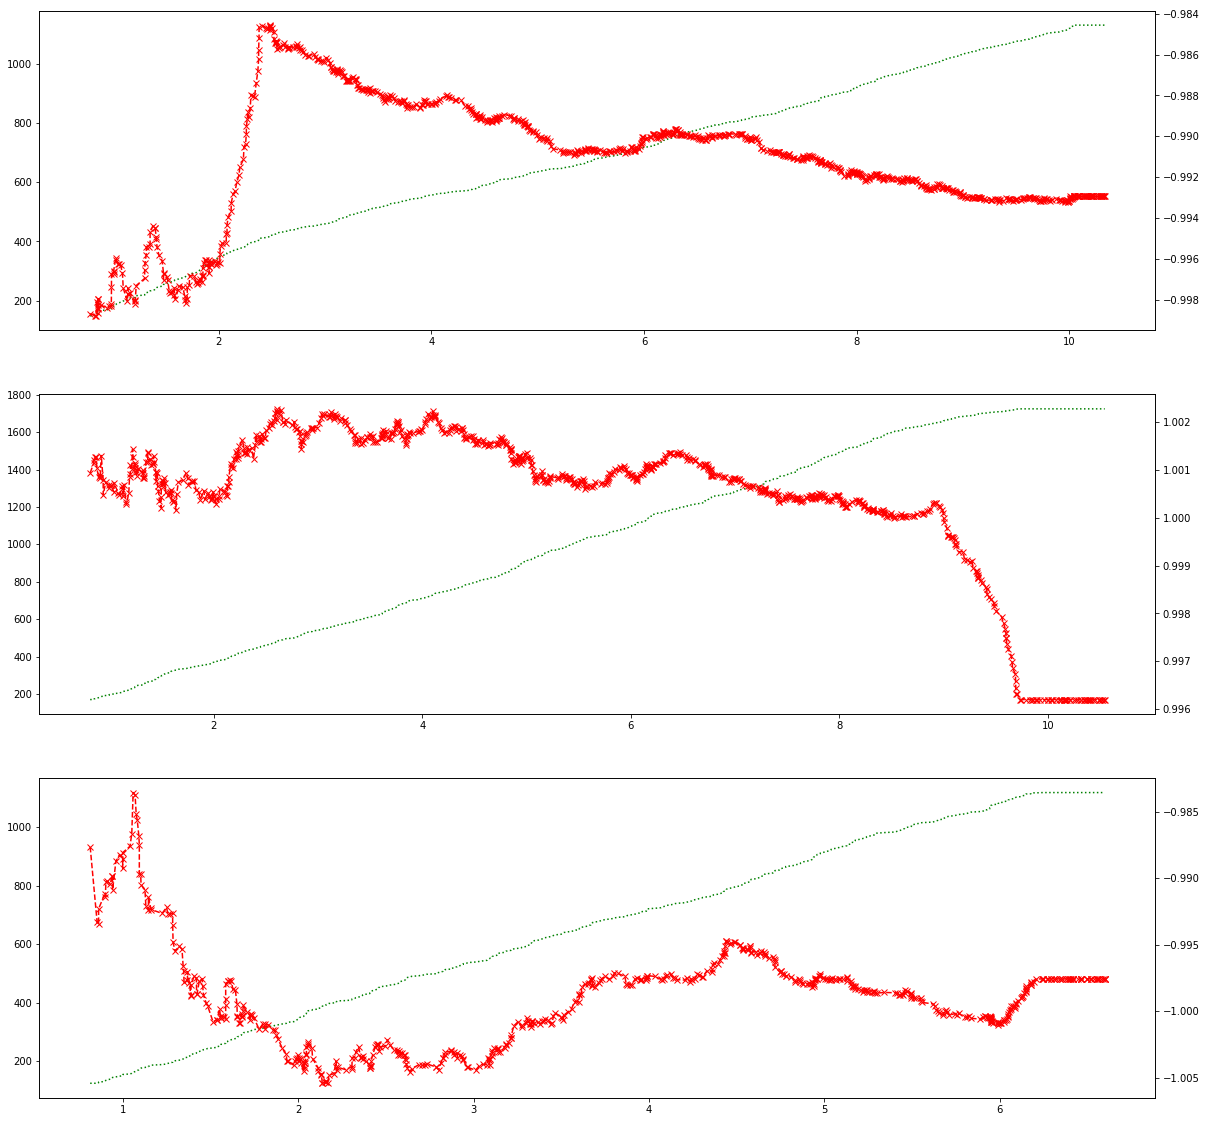

In [18]:
fig, axs = plt.subplots(3,1,figsize=[20,20])


eps = 0.25

time_thresh = 5/12


axn = 0

for timepoint in [5, 12, 21]:
    
    box_start = np.where((time_sub < (timepoint)) & (time_sub > (timepoint-time_thresh)))[0].min()
    box_end = np.where((time_sub < (timepoint+time_thresh)) & (time_sub > (timepoint)))[0].max()    
    
    new_start, new_end = box_start, box_end
    

    mean = np.mean(noise_journey_sub[new_start:new_end])


    counts = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]
    tdiffs = [time_sub[new_end]-time_sub[new_start]]

    lower_factor = 1.0
    upper_factor =1.0

    while (time_sub[new_start] > 0.1) & (time_sub[new_end] < 23.0):


        t_lower = time_sub[new_start]-lower_factor*time_thresh
        t_upper = time_sub[new_end]+upper_factor*time_thresh

        #print(time_sub[new_start], t_lower)

        check_start = np.where((time_sub < time_sub[new_end]) & (time_sub > t_lower))[0].min()

        if check_start != new_start:
            new_start = check_start
            lower_factor = 1.0
        else:
            lower_factor += 1


        check_end = np.where((time_sub < t_upper) & (time_sub > time_sub[new_start]))[0].max() 

        if check_end != new_end:
            new_end = check_end
            upper_factor = 1.0
        else:
            upper_factor += 1

        count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])

        #print(t_lower, t_upper, check_start, new_start, check_end, new_end)

        counts.append(count)
        tdiffs.append(t_upper-t_lower)
        #print(count)

        mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])

        count_thresh = 50
        if len(counts)>count_thresh:
            m0 = counts[-count_thresh]
            if all([m == m0 for m in counts[-count_thresh:]]):
                break

    new_start, new_end = box_start, box_end

    mean = np.mean(noise_journey_sub[new_start:new_end])
    eps = 0.25


    time_thresh = 5/12
    tdiffs2 = [time_sub[new_end]-time_sub[new_start]]
    counts2 = [get_counts(eps,mean)(noise_journey_sub[new_start:new_end])]
    means = [mean]

    while (new_start > 1) | (new_end < len(time_sub)-1):

        count = get_counts(eps,mean)(noise_journey_sub[new_start:new_end])

        counts2.append(count)

        if (new_start > 1):
            new_start -= 1
        if (new_end < len(time_sub)-1):
            new_end += 1

        mean = get_thresh_mean(eps,mean)(noise_journey_sub[new_start:new_end])
        means.append(mean)    

        tdiffs2.append(time_sub[new_end]-time_sub[new_start])

        count_thresh = 50
        if len(means)>count_thresh:
            m0 = means[-count_thresh]
            if all([m == m0 for m in means[-count_thresh:]]):
                break
     
    ax= axs[axn]
    #ax.plot(tdiffs, counts , 'b.-')
    ax.plot(tdiffs2, counts2, 'g:')
    axt = ax.twinx()    
    #axt.set_ylim(-1.2,1.2)    
    axt.plot(tdiffs2, means, 'rx--')
    axn+=1

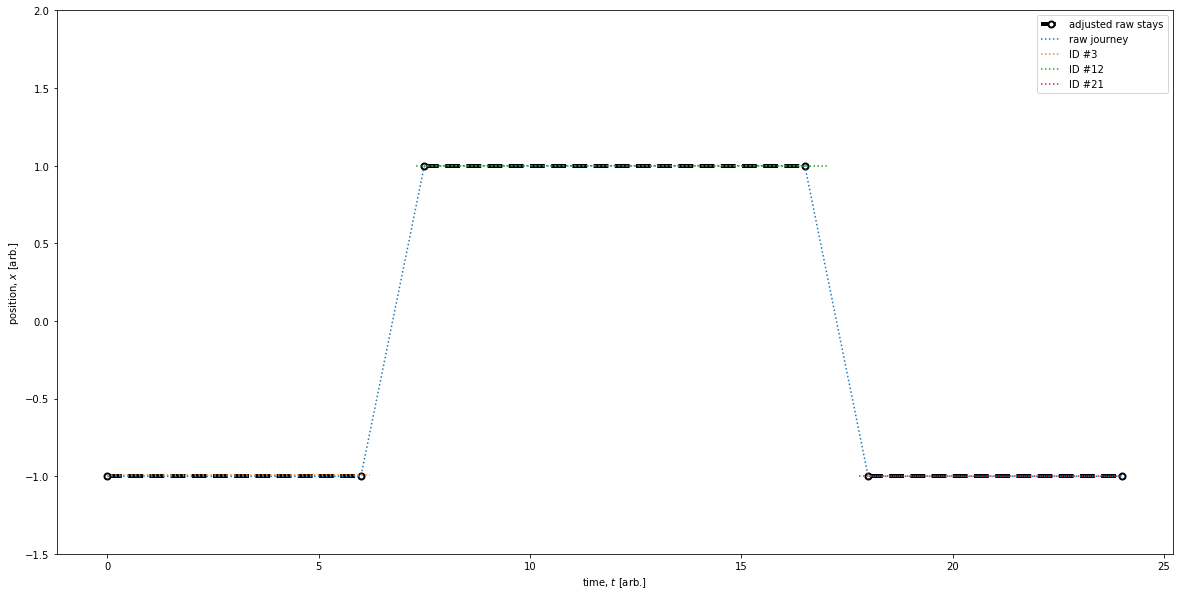

In [19]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

begin = t_segs[3]+1
begin_buff = begin-2
end = t_segs[4]-1
end_buff = end+2

loc = x_segs[3]


rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# The adjusted rwa-stays
plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, raw_journey_sub, ':', label='raw journey')
#ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

for timepoint in [3, 12, 21]:
    mean, start_ind, last_ind = box_method(time_sub,time_thresh,noise_journey_sub,eps,timepoint,False)
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean], ':', label=f'ID #{timepoint}')
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)
plt.grid(visible=False)
plt.legend();

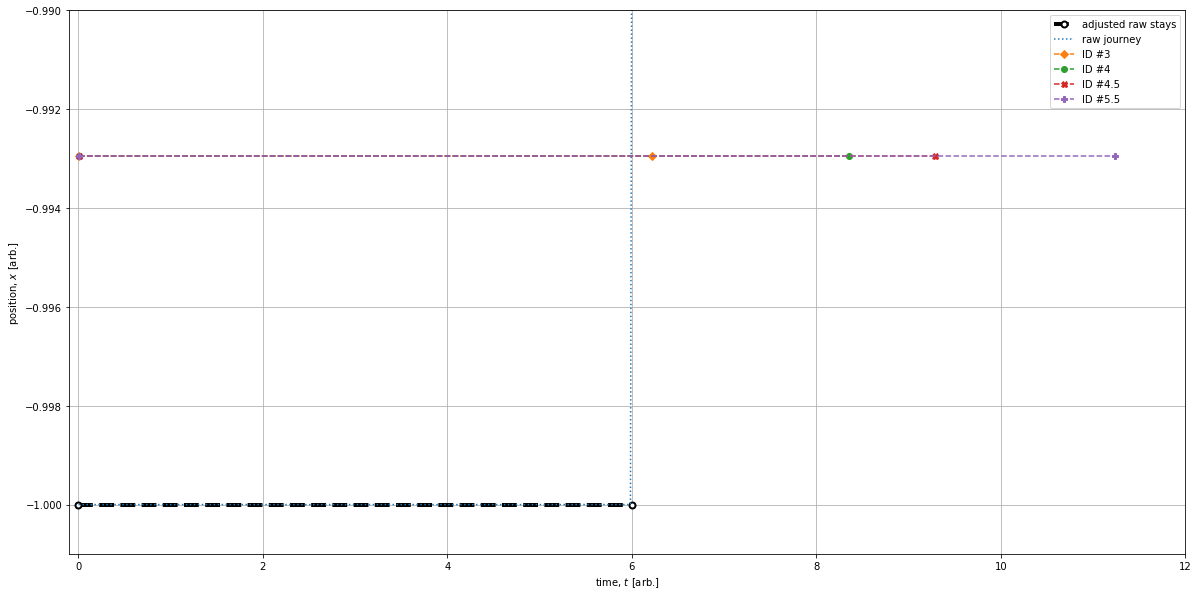

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

begin = t_segs[3]+1
begin_buff = begin-2
end = t_segs[4]-1
end_buff = end+2

loc = x_segs[3]


rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# The adjusted rwa-stays
plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, raw_journey_sub, ':', label='raw journey')
#ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

markers = ['D', 'o','X','P']
n=0
for timepoint in [3, 4, 4.5, 5.5]:
    mean, start_ind, last_ind = box_method(time_sub,time_thresh,noise_journey_sub,eps,timepoint,False)
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean],'--', marker=markers[n], label=f'ID #{timepoint}')
    n+=1
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.001, -0.99)
plt.xlim(-0.1, 12)
plt.grid(visible=True)
plt.legend();

**NOTE** The stopping criterion is sensitive to the starting timepoint, especially when it is asymmetrically placed within a stay. 
**TODO** The stopping criterion should be applied to both sides somewhat independently; otherwise, the boxes will continue to grow 

In [21]:
def check_means(means,count_thresh):
    m0 = means[-count_thresh]
    return all([m == m0 for m in means[-count_thresh:]])

def asymm_box_method(t_arr,time_thresh,x_loc,eps,timepoint, verbose=False):
    
    count_thresh = 50
        
    box_start = np.where((t_arr < (timepoint)) & (t_arr > (timepoint-time_thresh)))[0].min()
    box_end = np.where((t_arr < (timepoint+time_thresh)) & (t_arr > (timepoint)))[0].max()    

    new_start, new_end = box_start, box_end

    mean = np.mean(x_loc[new_start:new_end])

    tdiffs2 = [t_arr[new_end]-t_arr[new_start]]
    counts2 = [get_counts(eps,mean)(x_loc[new_start:new_end])]

    means = [mean]

    if verbose: print("\t1.", mean, new_start, new_end)            
        
    new_starts = []
    new_ends = []

    new_starts.append(new_start)
    new_ends.append(new_end)

    keep_running = True
    
    while keep_running:

        # Get the current count of events --> OBSOLETE
        count = get_counts(eps,mean)(x_loc[new_start:new_end])

        if (new_start > 1):
            new_start -= 1

        mean = get_thresh_mean(eps,mean)(x_loc[new_start:new_end])
        means.append(mean)    

        new_starts.append(new_start)
        
        #if verbose: print(mean, new_start, new_end)
        # When the mean either converges or stops
        if len(new_starts)>count_thresh:
            if check_means(means,count_thresh):
                break       
                
        keep_running = new_start > 1
        
    # If it converged early, get the converged results;
    if keep_running:
        last_mean = means[-count_thresh]
        last_start = new_starts[-count_thresh]
    else:
        # else, get the boundary value
        last_mean = mean
        last_start = new_start    
    
    new_start = last_start      
    mean = last_mean

    if verbose: print("\t2.", mean, new_start, new_end)            
            
    keep_running = True
    while keep_running:

        # Get the current count of events --> OBSOLETE
        count = get_counts(eps,mean)(x_loc[new_start:new_end])

        # check if the index is within bounds
        if (new_end < len(t_arr)-1):
            new_end += 1

        mean = get_thresh_mean(eps,mean)(x_loc[new_start:new_end])
        means.append(mean)    

        #new_starts.append(new_start)
        new_ends.append(new_end)
        
        #if verbose: print(mean, new_start, new_end)
        # When the mean either converges or stops
        if len(new_ends)>count_thresh:
            if check_means(means,count_thresh):
                break      
                
        keep_running = new_end < len(t_arr)-1
    
    # If it converged early, get the converged results;
    if keep_running:
        last_mean = means[-count_thresh]
        last_end = new_ends[-count_thresh]
    else:
        # else, get the boundary value
        last_mean = mean
        last_end = new_end      
            
    if verbose: print("\t3.", last_mean,last_start,last_end)                
    return last_mean,last_start,last_end

### Update: functionized

In [22]:
def extend_box(x_loc, working_index, fixed_index, means):

    keep_running = True
    
    indices = []
    
    if working_index < fixed_index: 
        # Go backwards in time
        direction = -1
    else: 
        # Go forwards in time
        direction = 1
        
    mean = means[-1]
    while keep_running:

        # Update and store the working index
        working_index += direction*1
        indices.append(working_index)
        
        # Update and store the mean
        if direction == -1:
            mean = get_thresh_mean(eps,mean)(x_loc[working_index:fixed_index])
        else:
            mean = get_thresh_mean(eps,mean)(x_loc[fixed_index:working_index])
        means.append(mean)    
        
        # When the mean either converges or stops
        if len(indices)>count_thresh:
            if check_means(means,count_thresh):
                break       
                    
        keep_running = (working_index > 1) & (working_index < len(x_loc)-1)
        
    return means, indices, keep_running

In [23]:
def check_means(means,count_thresh):
    m0 = means[-count_thresh]
    return all([m == m0 for m in means[-count_thresh:]])

def get_converged(converged, means, indices, count_thresh):
    
    # If it converged early, get the converged results;
    if converged & (len(indices)>count_thresh):
        last_mean = means[-count_thresh]
        last_index = indices[-count_thresh]
    else:
        # else, get the boundary value
        last_mean = means[-1]
        last_index = indices[-1] 
    
    return last_mean, last_index

In [24]:
def asymm_box_method_modular(t_arr, time_thresh, x_loc, eps, timepoint, count_thresh = 50, verbose=False):
        
    # 1.
    # Initialize and store the start, end points from the timepoint
    start = np.where((t_arr < (timepoint)) & \
                     (t_arr > (timepoint-time_thresh)))[0].min()
    end = np.where((t_arr < (timepoint+time_thresh)) & \
                   (t_arr > (timepoint)))[0].max()    

    starts = []
    ends = []

    starts.append(start)
    ends.append(end)
    
    # Initialize and store the mean for the region
    mean = np.mean(x_loc[start:end])
    means = [mean]
    
    
    # 2.
    if verbose: print("\t1.", mean, start, end)
    
    # Extend the box in the backwards direction
    means, indices, keep_running = extend_box(x_loc, start, end, means)
    starts += indices
    
    if verbose: print("\n\t2.", means[-1], starts[-1], end) 
    
    # If it converged early, get the converged results;
    mean, start = get_converged(keep_running, means, starts, count_thresh)

    #Debuging
    if verbose: print("\t2.1.", mean, start, end, keep_running) 


                
    # 3. 
    if verbose: print("\n\t3.", mean, start, end)
    
    # Extend the box in the forwards direction    
    means, indices, keep_running = extend_box(x_loc, end, start, means)
    ends += indices
            
    # If it converged early, get the converged results;
    mean, end = get_converged(keep_running, means, ends, count_thresh)
     
    #Debugging
    if verbose: print("\t3.1.", means[-1], start, end, keep_running) 
    
    # 4
    if verbose: print("\n\t4.", mean, start, end) 
        
    return mean, start, end

In [25]:
asymm_box_method_modular(time_sub,time_thresh,noise_journey_sub,eps,6.0,50,True)

	1. -0.8539559888669505 1034 1165

	2. -0.9929456568571601 1 1165
	2.1. -0.9929456568571601 1 1165 False

	3. -0.9929456568571601 1 1165
	3.1. -0.9929456568571601 1 1167 True

	4. -0.9929456568571601 1 1167


(-0.9929456568571601, 1, 1167)

In [26]:
asymm_box_method(time_sub,time_thresh,noise_journey_sub,eps,6.0,True)

	1. -0.8539559888669505 1034 1165
	2. -0.9929456568571601 1 1165
	3. -0.9929456568571601 1 1166


(-0.9929456568571601, 1, 1166)

In [27]:
for timepoint in np.arange(0.5,24.0,0.5):

    last_mean1,last_start1,last_end1 = asymm_box_method(time_sub,time_thresh,noise_journey_sub,eps,timepoint,False)
    first = f"{last_mean1} {last_start1} {last_end1}"
    
    last_mean2,last_start2,last_end2 = asymm_box_method_modular(time_sub,time_thresh,noise_journey_sub,eps,timepoint,50, False)
    second = f"{last_mean2} {last_start2} {last_end2}"  
    
    result = all([last_mean1==last_mean2, last_start1==last_start2, last_end1==last_end2])
    
    print(timepoint,":", first," ", second, str(result))    

0.5 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
1.0 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
1.5 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
2.0 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
2.5 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
3.0 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
3.5 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
4.0 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
4.5 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
5.0 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
5.5 : -0.9929456568571601 1 1135   -0.9929456568571601 1 1135 True
6.0 : -0.9929456568571601 1 1166   -0.9929456568571601 1 1167 False
6.5 : -0.0815683965569211 1103 1255   -0.0815683965569211 1103 1256 False
7.0 : -0.0815683965569211 1173 1318   -0.0815683965569211 1173 1319 False
7.5 : 0.9961997213106183 1275 3036   0.99619972

In [28]:
def get_thresh_duration(eps, mean):
    
    upper = mean+eps
    lower = mean-eps
    
    def meth(sub_arr, start):
        
        mask =  np.where((sub_arr < upper) & (sub_arr > lower))[0] + start
    
    
        return mask.min(), mask.max(0)
        
    return meth

In [29]:
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

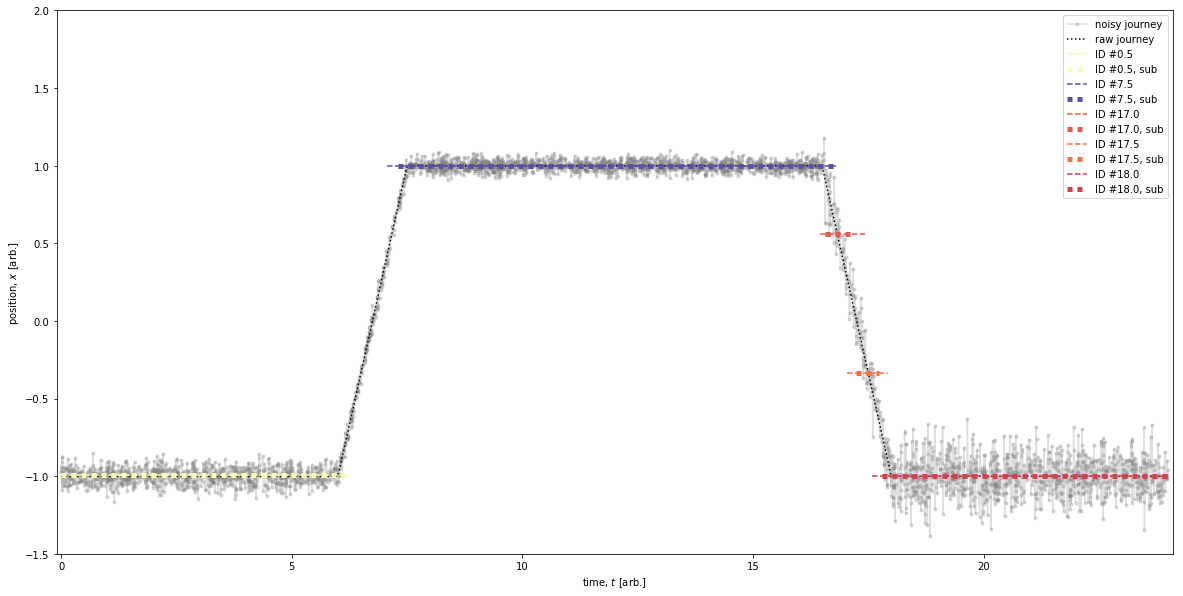

In [30]:
min_t, max_t = 0.5, 23.5

fig, ax = plt.subplots(1,1,figsize=(20,10))

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')
#ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

last_ind = 0

nnn = 0
for timepoint in np.arange(min_t,max_t,0.5):

    if timepoint < time_sub[last_ind]:
        continue    
    
    mean, start_ind, last_ind = asymm_box_method_modular(time_sub,time_thresh,noise_journey_sub,eps,timepoint)
    
    if time_sub[last_ind]-time_sub[start_ind] < time_thresh:
        continue
        
    t0, t1 = get_thresh_duration(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)        
    if time_sub[t1]-time_sub[t0] < time_thresh:
        continue    
    
    #print(timepoint,":", mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean], '--', color=colors[nnn], label=f'ID #{timepoint}')
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
                dashes=[1,1], linewidth=5, color=colors[nnn], label=f'ID #{timepoint}, sub')
    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)

#plt.xlim(min_t, max_t)
plt.xlim(-0.1, 24.1)

plt.grid(visible=False);
plt.legend();

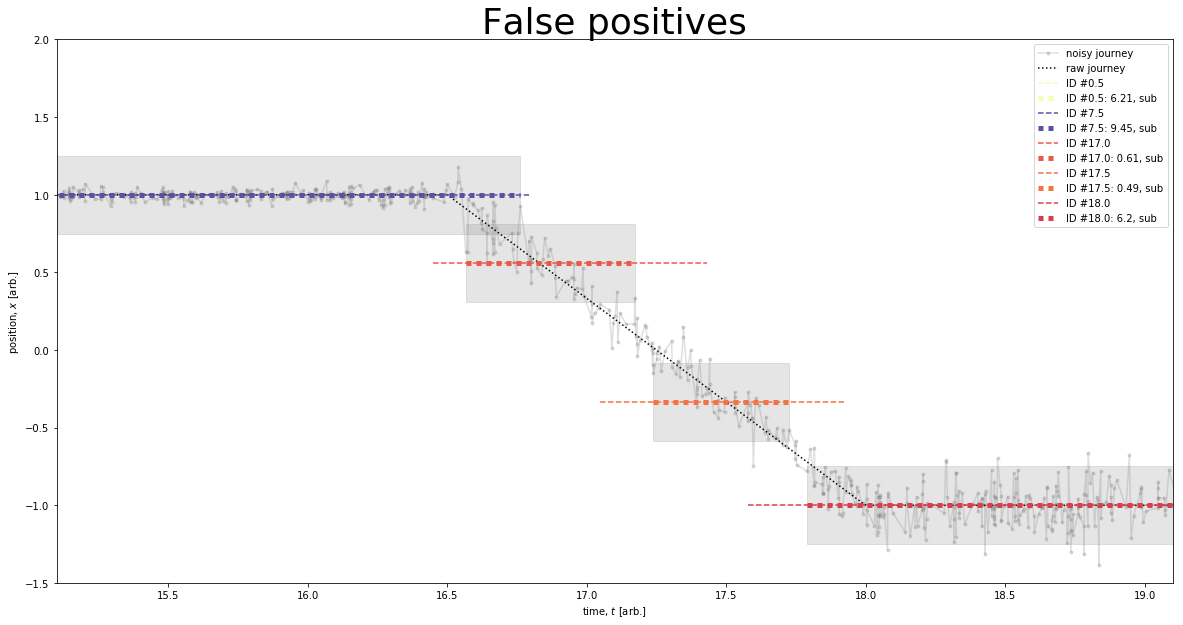

In [32]:
min_t, max_t = 0.5, 23.5

fig, ax = plt.subplots(1,1,figsize=(20,10))

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')
#ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

last_ind = 0

nnn = 0
for timepoint in np.arange(min_t,max_t,0.5):

    if timepoint < time_sub[last_ind]:
        continue    
    
    mean, start_ind, last_ind = asymm_box_method_modular(time_sub,time_thresh,noise_journey_sub,eps,timepoint)
    
    if time_sub[last_ind]-time_sub[start_ind] < time_thresh:
        continue
        
    t0, t1 = get_thresh_duration(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)        
    if time_sub[t1]-time_sub[t0] < time_thresh:
        continue    
    
    #print(timepoint,":", mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean], '--', color=colors[nnn], label=f'ID #{timepoint}')
    
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{timepoint}: {round(t_diff,2)}, sub')
    
    # Add the box
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[t0], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)

    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)

#plt.xlim(min_t, max_t)
plt.xlim(-0.1, 24.1)
plt.xlim(15.1, 19.1)

plt.title('False positives', fontsize=36)
plt.grid(visible=False);
plt.legend();

6.214166666666666 1 1134
6.214166666666666 1 1134
9.452222222222222 1297 3035
0.605833333333333 3008 3080
0.48944444444444457 3092 3157
6.197777777777777 3162 4317


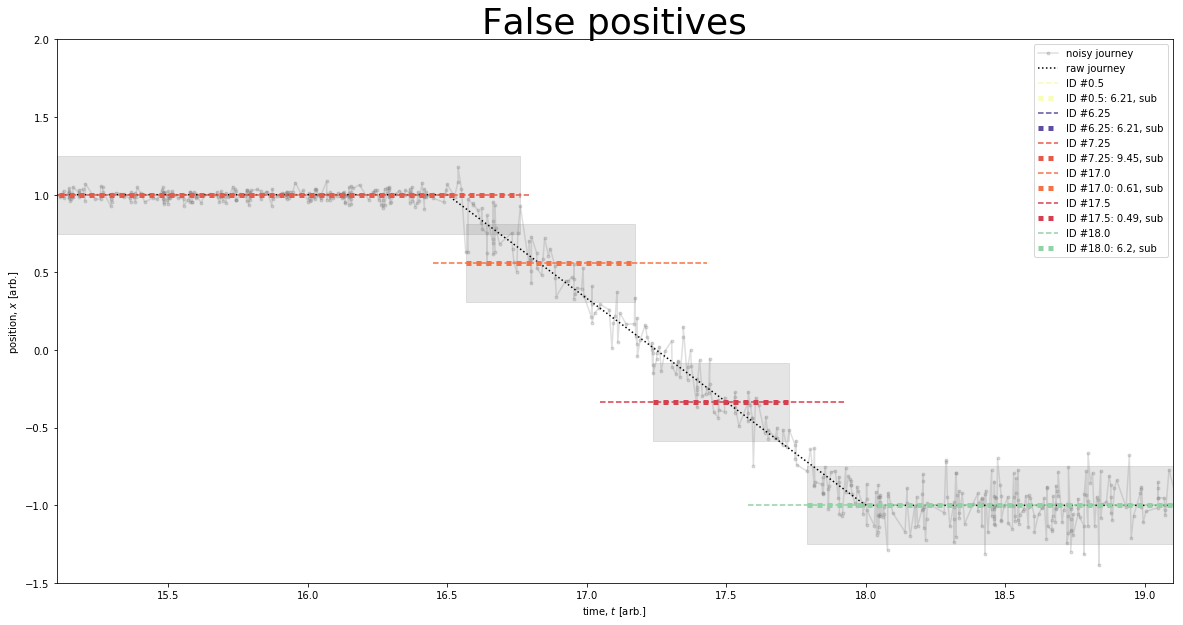

In [31]:
min_t, max_t = 0.5, 23.5

fig, ax = plt.subplots(1,1,figsize=(20,10))

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')
#ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

last_ind = 0

nnn = 0
for timepoint in np.arange(min_t,max_t,0.25):

    if timepoint < time_sub[last_ind]:
        continue    
    
    mean, start_ind, last_ind = asymm_box_method_modular(time_sub,time_thresh,noise_journey_sub,eps,timepoint)
    
    if time_sub[last_ind]-time_sub[start_ind] < time_thresh:
        continue
        
    t0, t1 = get_thresh_duration(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)        
    if time_sub[t1]-time_sub[t0] < time_thresh:
        continue    
    
    #print(timepoint,":", mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean], '--', color=colors[nnn], label=f'ID #{timepoint}')
    
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{timepoint}: {round(t_diff,2)}, sub')
    
    # Add the box
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[t0], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)

    print(t_diff,t0,t1)
    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)

#plt.xlim(min_t, max_t)
plt.xlim(-0.1, 24.1)
plt.xlim(15.1, 19.1)

plt.title('False positives', fontsize=36)
plt.grid(visible=False);
plt.legend();

**Notes**
* the $t$-extents of the boxes overlap
* in some cases, the $x$-extents of the boxes overlap
* `~P`'s are usually short

In [39]:
tstart,tend =  3008, 3080 ##3025,3107

xdata = time_sub[tstart:tend]
ydata = noise_journey_sub[tstart:tend]

In [35]:
def get_slope(t_subarr, x_subarr):
    
    ub_xdata = t_subarr - t_subarr.mean()
    ub_ydata = x_subarr - x_subarr.mean()
    
    return (ub_xdata.T.dot(ub_ydata))/(ub_xdata.T.dot(ub_xdata))

In [40]:
slope = get_slope(xdata, ydata)
print(slope)

-1.2199472993812628


In [41]:
ubxdata = time_sub[tstart:tend]
ubydata = noise_journey_sub[tstart:tend]
ubxdata = xdata - xdata.mean()
ubydata = ydata - ydata.mean()

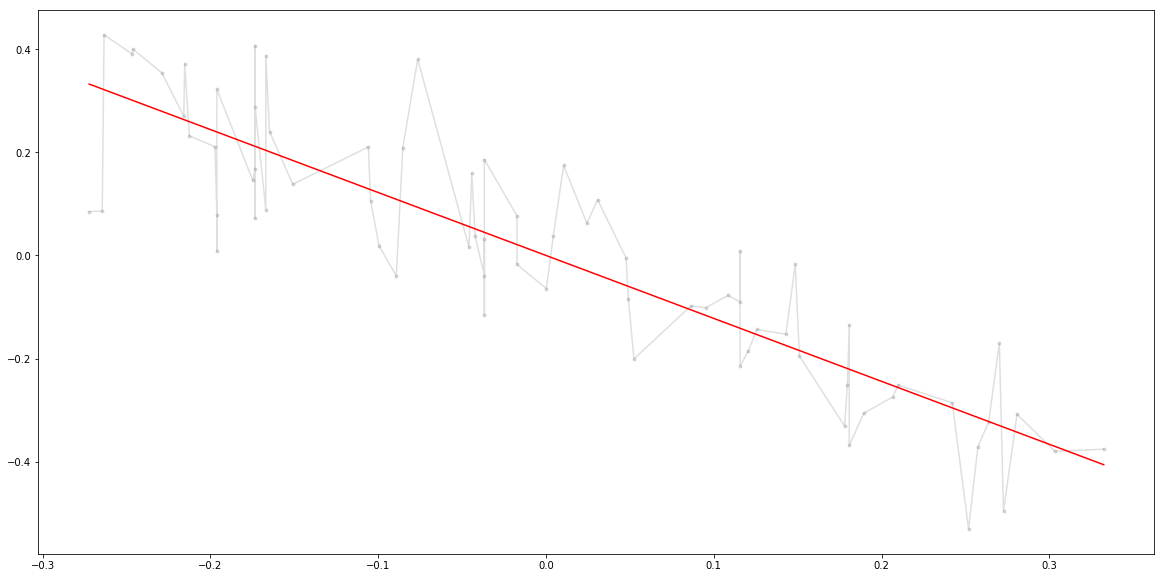

In [42]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(ubxdata, ubydata, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot([ubxdata[0],ubxdata[-1]],slope*np.array([ubxdata[0],ubxdata[-1]]), 'r-')

In [43]:
# 1. Add a bias
X_b = np.c_[np.ones(xdata.shape),xdata]

# Compute the params: slope and intercept
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(ydata)
print(theta_best)

# 3. make a prediction
X_pred = np.array([[xdata[0]],[xdata[-1]]])
X_b2 = np.c_[np.ones((2,1)), X_pred]
y_pred = X_b2.dot(theta_best)

[21.08717861 -1.2199473 ]


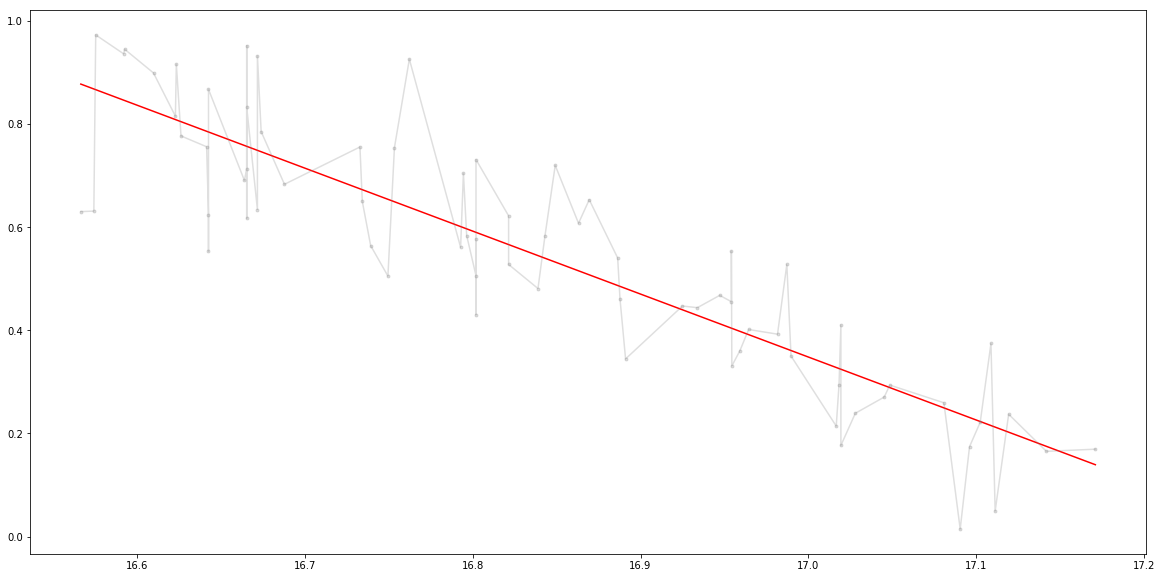

In [44]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(X_pred,y_pred, 'r-')
ax.plot(xdata, ydata, '.-', color='gray', label='noisy journey', alpha=0.25)

0.5 6.214166666666666 1 1134
6.25 6.214166666666666 1 1134
7.25 9.452222222222222 1297 3035
17.0 -1.2199472993812628
17.5 -1.2224191654817582
18.0 6.197777777777777 3162 4317


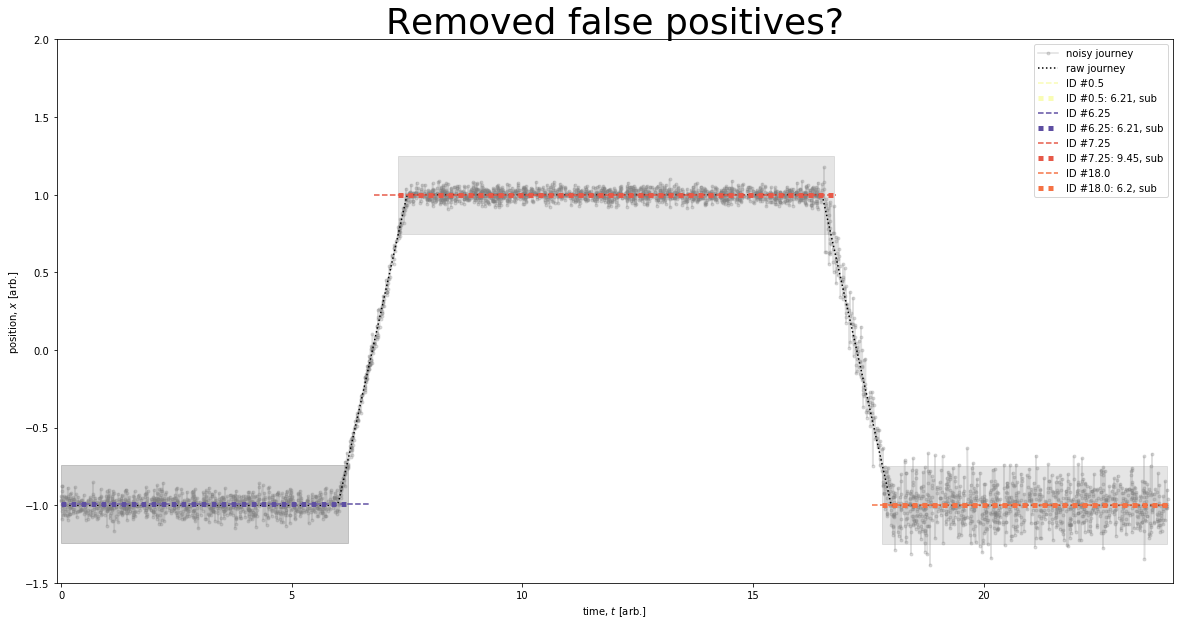

In [50]:
long_time_thresh = 1.0
slope_thresh = 1.0

min_t, max_t = 0.5, 23.5

fig, ax = plt.subplots(1,1,figsize=(20,10))

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')
#ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

last_ind = 0

nnn = 0
for timepoint in np.arange(min_t,max_t,0.25):

    if timepoint < time_sub[last_ind]:
        continue    
    
    mean, start_ind, last_ind = asymm_box_method_modular(time_sub,time_thresh,noise_journey_sub,eps,timepoint)
    
    if time_sub[last_ind]-time_sub[start_ind] < time_thresh:
        continue
        
    t0, t1 = get_thresh_duration(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)        
    if time_sub[t1]-time_sub[t0] < time_thresh:
        continue  

    # If the stay is less than 1 hour, check the slope of the segement
    if time_sub[t1]-time_sub[t0] < long_time_thresh:         
        xdata = time_sub[t0:t1]
        ydata = noise_journey_sub[t0:t1]
        slope = get_slope(xdata, ydata)
        print(timepoint, slope)
        if abs(slope) > slope_thresh: 
            continue     
        
    #print(timepoint,":", mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean], '--', color=colors[nnn], label=f'ID #{timepoint}')
    
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{timepoint}: {round(t_diff,2)}, sub')
    
    # Add the box
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[t0], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)

    print(timepoint, t_diff,t0,t1)
    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)

#plt.xlim(min_t, max_t)
plt.xlim(-0.1, 24.1)
#plt.xlim(15.1, 19.1)

plt.title('Removed false positives?', fontsize=36)
plt.grid(visible=False);
plt.legend();